## model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# build network
class Net(nn.Module):

    def __init__(self, shape):
        super(Net, self).__init__()
        x = torch.zeros(shape) # dummy inputs used to infer shapes of layers
        print(x.shape)
        
        self.conv1 = nn.Conv2d(x.shape[1], 128, (1, 3), bias=False)
        x = self.conv1(x)
        print(x.shape)
        
        self.conv2 = nn.Conv2d(x.shape[1], 64, (1, 3), bias=False)
        x = self.conv2(x)
        print(x.shape)
        
        self.conv3 = nn.Conv2d(x.shape[1], 32, (1, x.shape[3]), bias=False)
        x = self.conv3(x)
        print(x.shape)
        
        self.conv4 = nn.Conv2d(x.shape[1], 1, (1, 1), bias=False)
        x = self.conv4(x)
        print(x.shape)
        
        x = x.view(x.shape[0], -1) # 4d -> 2d
        print(x.shape)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = F.softmax(x, dim=1)
        return x

    def reset_parameters(self):
        for m in self.children():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()


# define loss function
class ReturnAsLoss(nn.Module):
    def __init__(self):
        super(ReturnAsLoss, self).__init__()

    def forward(self, output, y):
        '''negative logarithm return'''
        return -torch.sum(torch.log(torch.sum(output * y, dim=1)))

class BestStock(nn.Module):
    def __init__(self):
        super(BestStock, self).__init__()
        self._criteria = nn.CrossEntropyLoss()

    def forward(self, output, y):
        y_copy = y.clone()
        y_copy[:, 0] += 0.005 # be conservative
        return self._criteria(output, y_copy.argmax(dim=1))



## config

In [2]:
%reload_ext autoreload
%aimport dataset
%autoreload 1

from dataset import Dataset

# config
features = ['Open', 'High', 'Low', 'Close']
stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'INTC', 'CSCO', 'CMCSA', 'PEP', 'NFLX', 'ADBE']
# stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL']

epoch = 200 # repeat times
train_batch_num = 100
batch_size = 10
channel = len(features)
assets = len(stocks) + 1 # m assets including cash
window = 5 # using historical price in the past few days as features

# prepare data
data = Dataset('data.csv', features=features, stocks=stocks,
               train_batch_num=train_batch_num,
               batch_size=batch_size,
               window=window)


## training

RnnNet(
  (rnn1): RNN(44, 11, num_layers=2, bias=False, dropout=0.6)
  (conv): Conv1d(5, 1, kernel_size=(1,), stride=(1,), bias=False)
)
  1, loss:2.398, acc:+0.079, ret:+1.006
  2, loss:2.398, acc:+0.091, ret:+1.005
  3, loss:2.398, acc:+0.111, ret:+1.006
  4, loss:2.397, acc:+0.098, ret:+1.006
  5, loss:2.395, acc:+0.115, ret:+1.006
  6, loss:2.392, acc:+0.123, ret:+1.006
  7, loss:2.387, acc:+0.142, ret:+1.007
  8, loss:2.377, acc:+0.148, ret:+1.007
  9, loss:2.373, acc:+0.153, ret:+1.008
 10, loss:2.370, acc:+0.149, ret:+1.008
 11, loss:2.364, acc:+0.164, ret:+1.009
 12, loss:2.365, acc:+0.170, ret:+1.010
 13, loss:2.360, acc:+0.169, ret:+1.011
 14, loss:2.359, acc:+0.169, ret:+1.011
 15, loss:2.359, acc:+0.170, ret:+1.011
 16, loss:2.359, acc:+0.169, ret:+1.012
 17, loss:2.356, acc:+0.170, ret:+1.012
 18, loss:2.360, acc:+0.169, ret:+1.012
 19, loss:2.357, acc:+0.171, ret:+1.012
 20, loss:2.355, acc:+0.170, ret:+1.014
 21, loss:2.357, acc:+0.169, ret:+1.011
 22, loss:2.355, acc:+0

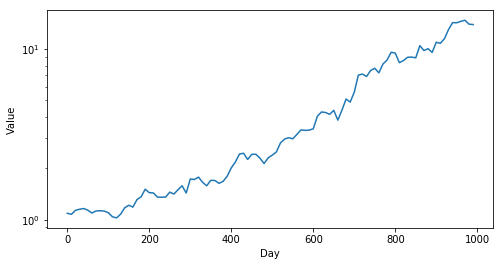

In [3]:
import os
import logging
from datetime import datetime
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
from networks import *


save_path = pathlib.Path("stats", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
save_path.mkdir(parents=True, exist_ok=True)

# create logger
logger = logging.getLogger('nn')
logger.handlers = []
logger.setLevel(logging.DEBUG)
file = logging.FileHandler(os.path.join(save_path, 'log'))
console = logging.StreamHandler()
logger.addHandler(file)
logger.addHandler(console)

# construct model
#net = Net((batch_size, channel, assets, window))
net = RnnNet((batch_size, channel, assets, window))
#net=Conv2DNet((batch_size, channel, assets, window))
#logger.info(net_)
net.reset_parameters()
logger.info(net)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = BestStock()

def train_step(X, y):
    X, y = torch.Tensor(X), torch.Tensor(y)
    #print(X.shape, y.shape)
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()    # Does the update
    return (
        loss.item(),
        np.mean(list(output.argmax(1) == y.argmax(1))), # # accuray
        torch.prod(torch.sum(output * y, dim=1)).item() # cumulative return in this batch
    )

# loop over epoch and batch
for e in range(epoch):
    current_epoch = []
    for i, (X, y) in enumerate(data.train_batch()):
        current_epoch.append(train_step(X, y))
    current_epoch = np.array(current_epoch)
    logger.info("{:3d}, loss:{:.3f}, acc:{:+.3f}, ret:{:+.3f}".format(
        e+1,
        *(current_epoch.mean(axis=0))))
    torch.save({
        'net': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'criterion': criterion.state_dict()
    }, os.path.join(save_path, 'state.pt'))
fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.set_xlabel('Day')
ax1.set_ylabel('Value')
ax1.set_yscale('log')
# cumulative return of the last epoch over the whole training period
ax1.plot(np.arange(0, len(current_epoch) * batch_size, batch_size), (pd.Series(current_epoch[:, 2])).cumprod())
fig1.savefig(os.path.join(save_path, 'training_conv_rnn.pdf'))

## back test

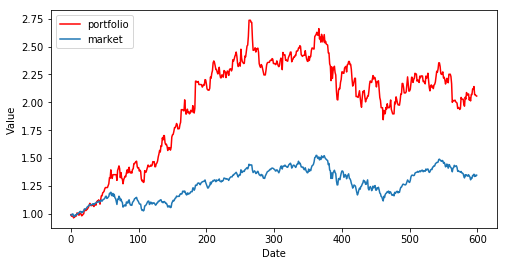

In [4]:
def load_model(path):
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint['net'])
    net.eval()
# load_model(save_path)

backtest_return = []
test_batch_num = 600

def reallocate(w):
    # assets that have weights lower than cash are eliminated
    cash = w[:, 0][:, None]
    w[w < cash] = 0
    w[:, 0] += 1-w.sum(dim=1)
    return w

for i, (X, y) in enumerate(data.test_batch(batch_size=1)):
    X, y = torch.Tensor(X), torch.Tensor(y)
    # print(X.shape, y.shape)
    output = net(X)
    output = reallocate(output)
    backtest_return.extend(torch.sum(output * y, dim=1))
    if test_batch_num and i+1 >= test_batch_num:
        break
fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
# cumulative return in the last epoch over the whole training period
ax2.plot((pd.Series(backtest_return)).cumprod(), label='portfolio', color='red')
ax2.plot(data.baseline()[:len(backtest_return)], label='market')
ax2.legend(loc='upper left')
fig2.savefig(os.path.join(save_path, 'test_conv_rnn.pdf'))